### AdventureWorks Försäljningsanalys


I den här analysen så redogör vi för AdventureWorks försäljning genom att titta på vilka produkter de innehar, vilka regioner de säljer i, hur intäkterna skiljer sig baserat på årstid, vilka typer av kunder de har och vilka produkter som de bör satsa mer/mindre på.

In [ ]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

user = "SA"
password = quote_plus("")
server = '127.0.0.1,1433'
database = ''
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\Jakob\AppData\Local\Temp\ipykernel_4444\2557269207.py:26: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conm:
        return pd.read_sql(text(sql), conm)

#### Antal produkter per kategori
**Affärsfråga**
* AdventureWorks innehar 4 huvudkategorier av produkter: Cyklar, kläder, accessoarer och komponenter.
* Men hur många unika produkter innehar Adventureworks i respektive kategori? Vilken kategori innehar flest respektive minst antal unika produkter?

**Metod**

För att finna ut antal produkter som respektive kategori innehar så väljer vi att i SQL räkna antal unika produktnamn. Detta visualiserar vi sedan med ett stapeldiagram, då vi har 4st kategorier, och vi vill jämföra antalet som finns i respektive kategori (siffror).

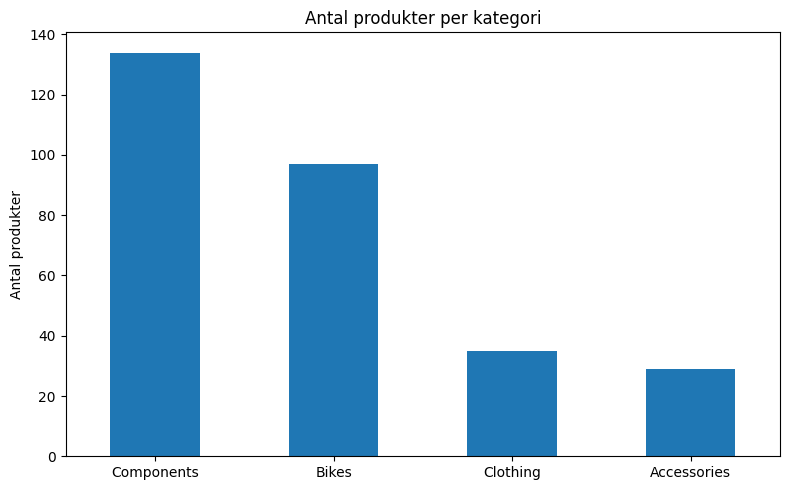

In [3]:
query_1 = """
SELECT ppc.name as Kategori, COUNT(DISTINCT pp.Name) as AntalProdukter, SUM(COUNT(Distinct pp.Name)) OVER() as TotaltAntalProdukter
FROM Production.Product pp
LEFT JOIN Production.ProductSubcategory pps ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory ppc ON pps.ProductCategoryID = ppc.ProductCategoryID
WHERE ppc.name IS NOT NULL
GROUP BY ppc.Name
ORDER BY AntalProdukter DESC
"""

query_1_df = query_df(query_1)
query_1_df

fig, ax = plt.subplots(figsize=(8,5))
query_1_df.plot(kind="bar", y='AntalProdukter', x = 'Kategori', ax=ax, legend=False)
ax.set_title("Antal produkter per kategori")
ax.set_xlabel("")
ax.set_ylabel("Antal produkter")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()


**Lärdomar**

I stapeldiagrammet kan vi se hur antalet unika produkter som AdventureWorks innehar skiljer sig i respektive kategori, där kategorin "Komponenter" innehar över 130 produkter, medan kläder och accessoarer ligger på under 40 unika produkter vardera. Detta kan ge en indikation på vilken produkt-typ AdventureWorks har valt att nischa sig i. Men vi bör vara försiktiga med att dra några absoluta slutsatser då det exempelvis krävs betydligt färre antal unika cyklar än komponenter för att trots det kalla sig själv en cykelförsäljare istället för en komponent-försäljare. Vi bör därför analysera vidare.

__________________

#### Intäkter per kategori och produkt-typ
**Affärsfråga**

* Hur stora intäkter genererar respektive kategori och underkategori?

**Metod**

Jag börjar med att gruppera datan i subkategorier i SQL, där jag multiplicerar kostnaden för en vara med antal av denna vara som sålts, och sedan summerar jag alla intäkter den varan genererat totalt. Anledningen till att jag kategoriserar i subkategorier är att när jag väl gjort detta, så kan jag därefter använda samma SQL query för att gruppera datan i python enligt huvudkategorier på ett enkelt sätt. 

Sedan visualerar jag all denna data i 3st liggande stapeldiagram, där det första demonstrerar intäkterna per kategori, och de nästkommande två demonstrerar intäkter per subkategori, där den första tar med alla subkategorier, och nästa enbart kollar på top 10 subkategorier. 




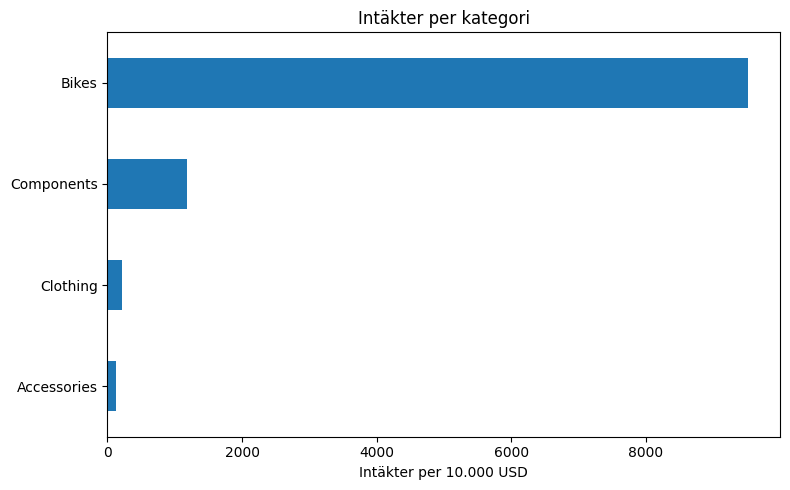

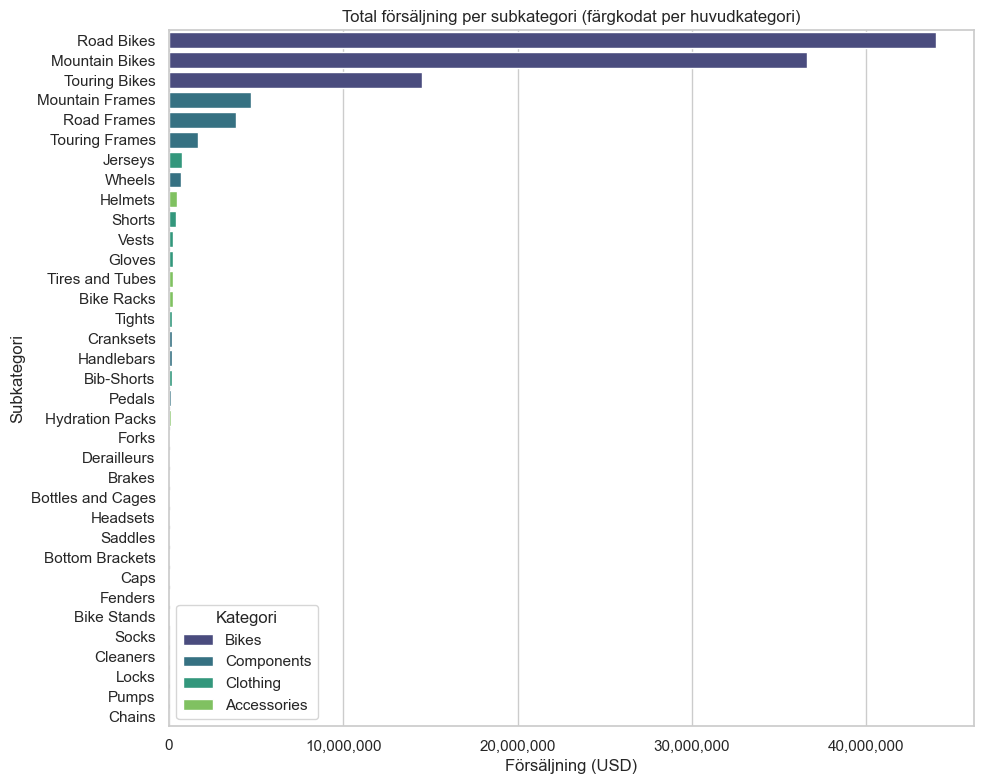

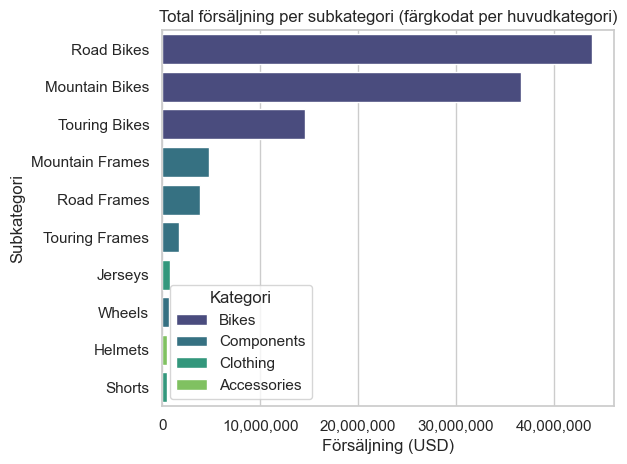

In [4]:
query_2 = """
SELECT ppc.name AS Kategori, pps.name AS SubKategori, SUM(sod.UnitPrice * sod.OrderQty) AS Intäkter
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product pp ON sod.ProductID = pp.ProductID
LEFT JOIN Production.ProductSubcategory pps ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory ppc ON pps.ProductCategoryID = ppc.ProductCategoryID
GROUP BY pps.Name, ppc.name 
ORDER BY Intäkter DESC
"""

query_2_df = query_df(query_2)
query_2_grouped_categories_df = query_2_df.groupby(["Kategori"])["Intäkter"].sum().sort_values(ascending=True)
query_2_grouped_categories_df = query_2_grouped_categories_df / 10000

# Stapeldiagram 1 - huvudkategori
fig, ax = plt.subplots(figsize=(8,5))
query_2_grouped_categories_df.plot(kind="barh", y='Intäkter', x = 'Kategori', ax=ax, legend=False)
ax.set_title("Intäkter per kategori")
ax.set_xlabel("Intäkter per 10.000 USD")
ax.set_ylabel("")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

# Stapeldiagram 2 - alla subkategorier
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=query_2_df, 
    x='Intäkter', 
    y='SubKategori', 
    hue='Kategori', 
    dodge=False, 
    palette='viridis' 
)
plt.title("Total försäljning per subkategori (färgkodat per huvudkategori)")
plt.xlabel("Försäljning (USD)")
plt.ylabel("Subkategori")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

# Stapeldiagram 3 - Top 10 subkategorier
ax = sns.barplot(
    data=query_2_df.head(10), 
    x='Intäkter', 
    y='SubKategori', 
    hue='Kategori', 
    dodge=False, 
    palette='viridis' 
)
plt.title("Total försäljning per subkategori (färgkodat per huvudkategori)")
plt.xlabel("Försäljning (USD)")
plt.ylabel("Subkategori")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()




**Lärdomar**

* Vid en första anblick i det första stapeldiagrammet ser vi att kategorin cyklar genererar den absoluta majoriteten av intäkterna, mer än de 3 övriga kategorierna tillsammans. 
* I stapeldiagram 2 så ser vi att det även där är 3st typer av cyklar som dominerar intäkterna.
* Stapeldiagram 3 visar på ett tydligare sätt hur olika subkategorier skiljer sig åt, där "Mountain Frames" innehar en knapp tredjedel av "Touring Bikes" intäkter. 

_______________

#### Försäljning över tid

**Affärsfråga** 

* Hur har försäljningen sett ut över tid? 

**Metod**

För att ta reda på detta gör jag först en SQL query där jag gör om alla Orderdatum så det blir det sista datumet i månaden ordern är beställd. Detta för att på ett lätt sätt sedan kunna gruppera datan i Orderdatum för att få grupperingen baserad på månaden. 

Därefter summerar jag intäkterna som skett i respektive månad, och slutligen visualiserar jag intäkterna som skett över tid med ett linjediagram, då man på ett övergripligt sätt kan urskilja om försäljningen går upp eller ner över tid, samt även jämföra en viss månad i exempelvis 2022, med samma månad år 2023, och se hur dessa skiljer sig.

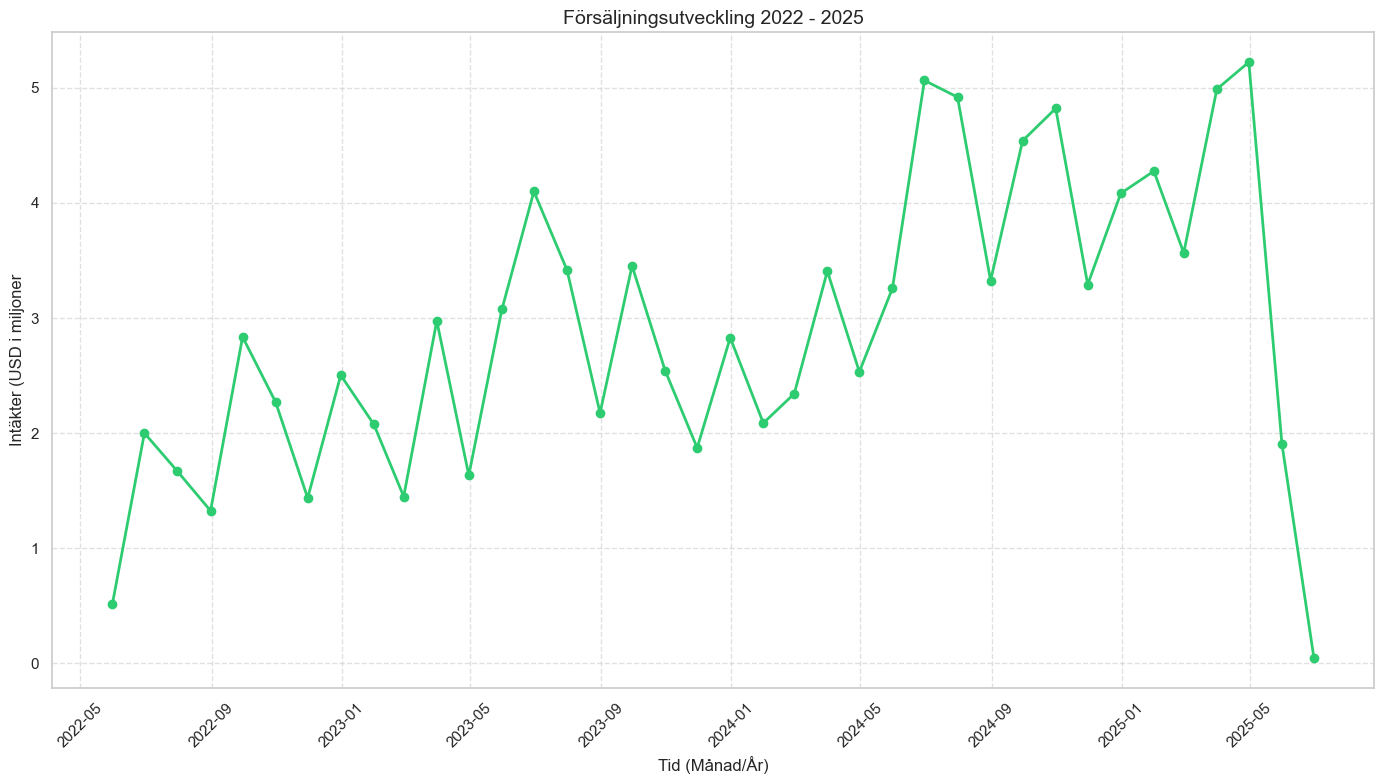

In [5]:
query_3 = """
SELECT 
    EOMONTH(OrderDate) AS Månadsperiod, 
    SUM(SubTotal) AS Intäkter
FROM Sales.SalesOrderheader
GROUP BY EOMONTH(OrderDate) 
ORDER BY Månadsperiod ASC;
"""

query_3_df = query_df(query_3)
query_3_df['Intäkter'] = query_3_df['Intäkter'] / 1000000

plt.figure(figsize=(14, 8))
plt.plot(query_3_df['Månadsperiod'], query_3_df['Intäkter'], 
         marker='o',         
         linestyle='-',       
         linewidth=2,         
         color='#2ecc71')     

plt.xticks(rotation=45)
plt.title('Försäljningsutveckling 2022 - 2025', fontsize=14)
plt.xlabel('Tid (Månad/År)')
plt.ylabel('Intäkter (USD i miljoner')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Lärdomar**

Försäljningstrenden verkar gå upp över tid, även när vi jämför enskilda månader från år till år, där exempelvis januari-försäljningen och september-försäljningen stadigt gått upp varje år. 

Men någonting sker i juni och juli månad år 2025 som kräver vidare undersökning. Möjligtvis så räknas enbart en del av juni månad med, och juli blir sedan räknad som 0 i intäkt. Vidare undersökning krävs.

______

#### Intäkter och antal ordrar per år
**Affärsfråga**
* Hur många ordrar läggs per år?
* Hur stora är intäkterna per år?
* Hur stor intäkt genererar medel-ordern per år?

**Metod**

Eftersom den tillgängliga datan i AdventureWorks börjar fr.o.m 2022-05-30, och sträcker sig till 2025-06-29, så blir intäkterna inte rättvisa ifall man räknar per år, och heller inte om man räknar per år där start-datum är 2022-05-30. Därför valde jag att skapa brutna räkenskapsår som sträcker sig mellan 2022-05-30 till 2025-05-30.

Jag räknade ihop antal unika ordrar och de summerade intäkterna per brutet räkenskapsår i en SQL query, men jag glömde att räkna ut AOV (Average Order Value), men korrigerade det sedan i python.

För att se hur intäkterna skiljde sig per år så skapade jag även en kolumn vid namn "+ Resultat". Men iom visualiseringen i stapeldiagrammet så kom jag fram till att den kolumnen ej behövdes, då man ändå på ett övergripligt sätt kunde jämföra intäkterna åren emellan.

För att lösa problemet med de olika enheterna (antal ordrar kontra intäkter) i samma stapeldiagram så använde jag en logaritmisk skala så alla staplarna kunde vara närvarande i samma stapeldiagram.

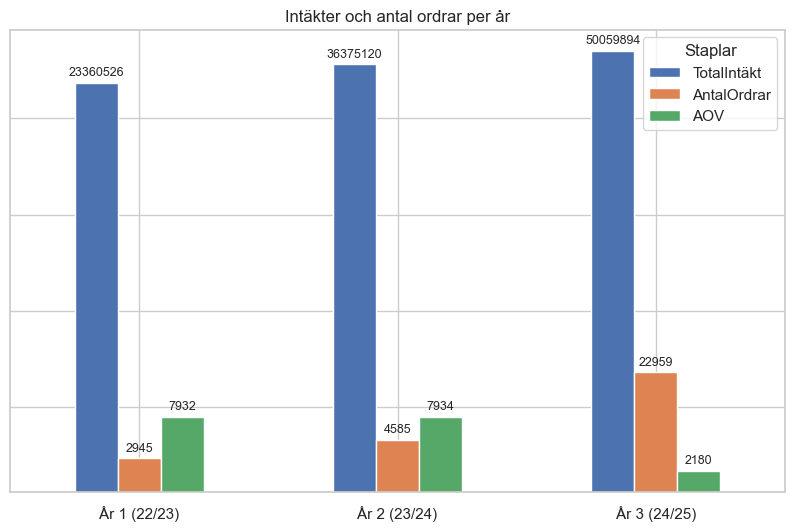

In [6]:
query_3 = """
WITH OrderData AS (
    SELECT 
        SubTotal,
        SalesOrderID,
        CASE 
            WHEN OrderDate >= '2022-05-30' AND OrderDate < '2023-05-30' THEN 'År 1 (22/23)'
            WHEN OrderDate >= '2023-05-30' AND OrderDate < '2024-05-30' THEN 'År 2 (23/24)'
            WHEN OrderDate >= '2024-05-30' AND OrderDate < '2025-05-30' THEN 'År 3 (24/25)'
            ELSE 'Övrigt'
        END AS BrutetRäkenskapsår
    FROM Sales.SalesOrderheader
)
SELECT 
    BrutetRäkenskapsår,
    SUM(SubTotal) AS TotalIntäkt,
    COUNT(DISTINCT SalesOrderID) AS AntalOrdrar
FROM OrderData -- Här hämtar vi från CTE:n istället för originaltabellen
WHERE BrutetRäkenskapsår != 'Övrigt' AND BrutetRäkenskapsår IS NOT NULL
GROUP BY BrutetRäkenskapsår
ORDER BY BrutetRäkenskapsår;
"""

query_3_df = query_df(query_3)
query_3_df['AOV'] = query_3_df['TotalIntäkt'] / query_3_df['AntalOrdrar']

k = 0
list_of_result = []
for i in query_3_df['TotalIntäkt']:
    list_of_result.append(round(i-k, 2))
    k = i
query_3_df['+ Resultat'] = list_of_result


ax = query_3_df.plot(
    x='BrutetRäkenskapsår', 
    y=['TotalIntäkt', 'AntalOrdrar', 'AOV'],
    kind='bar',
    logy=True, 
    figsize=(10, 6))

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=9, fmt='%.0f')

ax.set_yticklabels([])
plt.title('Intäkter och antal ordrar per år')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0) 
plt.legend(title='Staplar')
plt.show()

**Lärdomar**
I stapeldiagrammet ser vi att totalintäkterna för respektive år stadigt ökar. Snittordern ligger på nästan precis samma mellan år 1 och år 2, så det enda som ökar mellan dessa år är antal ordrar.

Men någonting intressant sker under år 3: Snittordern går ner med en betydande siffra (från 7934 År 2 till 2180 År 3), och trots det går intäkterna fortfarande upp. Detta kan vi se förklaringen för i Antal ordrar, som gått från 4585 till hissnande 22959. 

Detta innebär att den generella orderintäkten har gått ner med 73% medan antal ordrar gått upp med 400%.

**Slutsats** 
Kunder lägger fler ordrar med mindre summor under År 3, i jämförelse med År 1 och År 2.

Det finns flera möjliga förklaringar till detta, och samtliga kräver djupare analys:
* En och samma kund handlar fler gånger men med mindre summor än tidigare, och kommer således upp till mer eller mindre samma belopp som År 1 och År 2?
För att se om detta stämmer kan vi analysera enskilda kundbeteenden. Skulle denna hypotes stämma så kan man exempelvis öka fraktkostnaden för att skapa en tröskel för kunden så denne inte lägger flera mindre ordrar utan väntar tills den kommit fram till vilka produkter denne faktiskt vill ha.
* En annan typ av produkt har blivit populär under År 3, som säljer i större kvantitéer till fler kunder men som säljer för en mindre summa än tidigare populära produkter.
För att se om detta stämmer krävs en produktanalys över tid, och se om popularitet bland enskilda produkter skiljer sig mellan de olika åren.

_______


#### Intäkter per produkt

**Affärsfråga**

* Vilka produkter generar mest intäkter?

**Metod**

SQL query där jag grupperar baserat på Produktnamn (Produktmodel) och huvudkategori. Anlednignen till att jag även grupperar baserat på huvudkategori är att jag då kan använda mig av huvudkategorierna för att färglägga de olika staplarna av produkter baserat på deras huvudkategori. 

I och med att det som ska visualiseras är kategorier och intäkter så görs detta bäst med ett stapeldiagram. Jag väljer ett liggande stapeldiagram så vi på ett enkelt sätt kan rangordna produkternas intäkter.

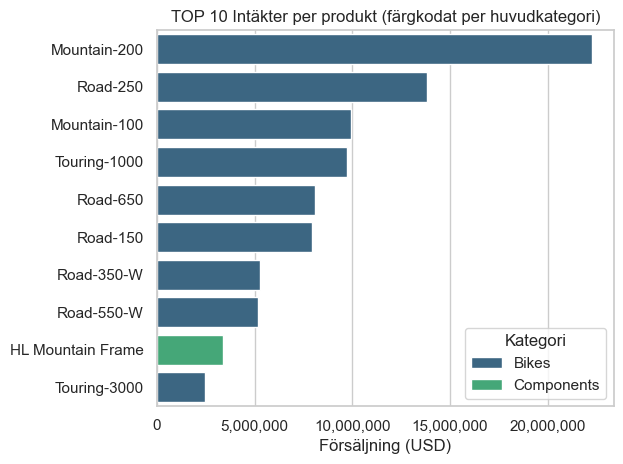

In [7]:
query_4 = """
SELECT TOP 10
    pm.Name AS ProduktNamn,
    SUM(sod.LineTotal) AS TotalIntäkt,
    SUM(sod.OrderQty) AS TotaltSåldaProdukter,
    COUNT(sod.SalesOrderID) AS AntalOrdrarMedProdukt,
    CAST(SUM(sod.OrderQty) AS FLOAT) / COUNT(sod.SalesOrderID) AS SnittPerOrder,
    ppc.name AS Kategori
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product pp ON sod.ProductID = pp.ProductID
LEFT JOIN production.ProductModel pm ON pp.ProductModelID = pm.ProductModelID
LEFT JOIN Production.ProductSubcategory pps ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory ppc ON pps.ProductCategoryID = ppc.ProductCategoryID
GROUP BY pm.name, ppc.name
ORDER BY TotalIntäkt DESC;
"""

query_4_df = query_df(query_4)

ax = sns.barplot(
    data=query_4_df, 
    x='TotalIntäkt', 
    y='ProduktNamn', 
    hue='Kategori', 
    dodge=False, 
    palette='viridis' 
)

plt.title("TOP 10 Intäkter per produkt (färgkodat per huvudkategori)")
plt.xlabel("Försäljning (USD)")
plt.ylabel("")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

**Lärdomar**

I stapeldiagrammet ser vi att bland de top 10 produkterna som genererar störst intäkt så är 9 av dessa cyklar, medan endast en produkt tillhör huvudkategorin "komponenter". 

Om vi har i åtanke att det finns över 130 komponenter och över 90 cyklar som säljs av AdventureWorks, så ser vi här klart och tydligt att trots att cyklar dominerar de totala intäkterna till AdventureWorks så finns där enskilda komponenter som står för en betydande andel av intäkterna i jämförelse med majoriteten av cyklarna.

Cykeln "Mountain-200" är helt klart den cykeln som genererar störst intäkt. Men genererar denna cykel också störst vinst, efter att man räknar bort produktions och inköpskostnad? Vidare analys krävs.



____

#### Intäkter och antal unika kunder per region

**Affärsfråga**
* Hur stora intäkter genererar respektive land och hur många unika kunder finns i dessa?
* Hur stora intäkter genererar respektive region och hur många unika kunder finns i dessa?
* Består kunderna av företagskunder eller privata kunder?

**Metod**
* SQL-query där jag skapar Region genom att jag lägger ihop regionens namn med landet.
* Räknar unika kunder samt intäkter.
* Skapar Kundtyp genom att se om det finns StoreID eller PersonID

När jag visualiserar detta så väljer jag att skapa 3 stapeldiagram, där 2 av dessa delar y-axel.

Stapeldiagram 1: Visualiserar intäkter och unika kunder per land, där jag använder logaritmisk skala för att datan ska bli överskådlig. Detta så man får en översikt över hur många kunder som finns i respektive land och deras intäkter så man direkt knyter an till hur mycket den generella kunden spenderar.

Stapeldiagram 2+3: Visualiserar intäkter och unika kunder per region och kundtyp. Genom att dela y-axel så kan man jämföra de olika regionerna och får då en översikt i om en region främst präglas av företagskunder eller privatkunder, och hur mycket respektive kundtyp genererar i intäkter.

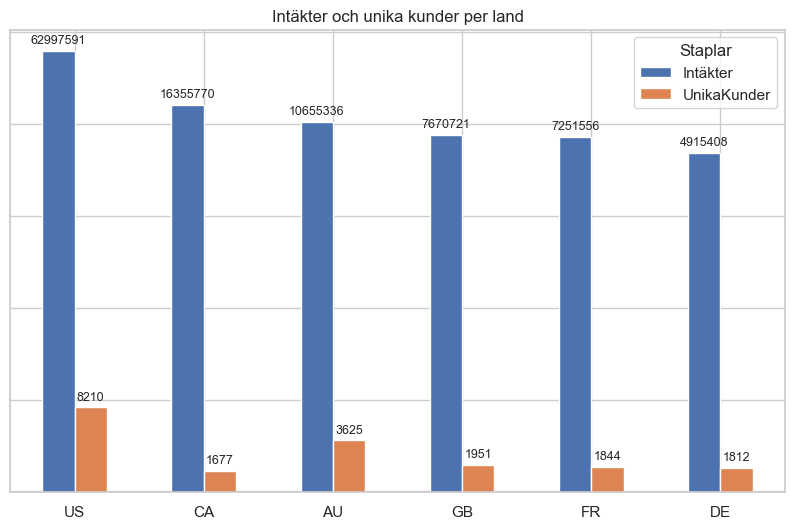

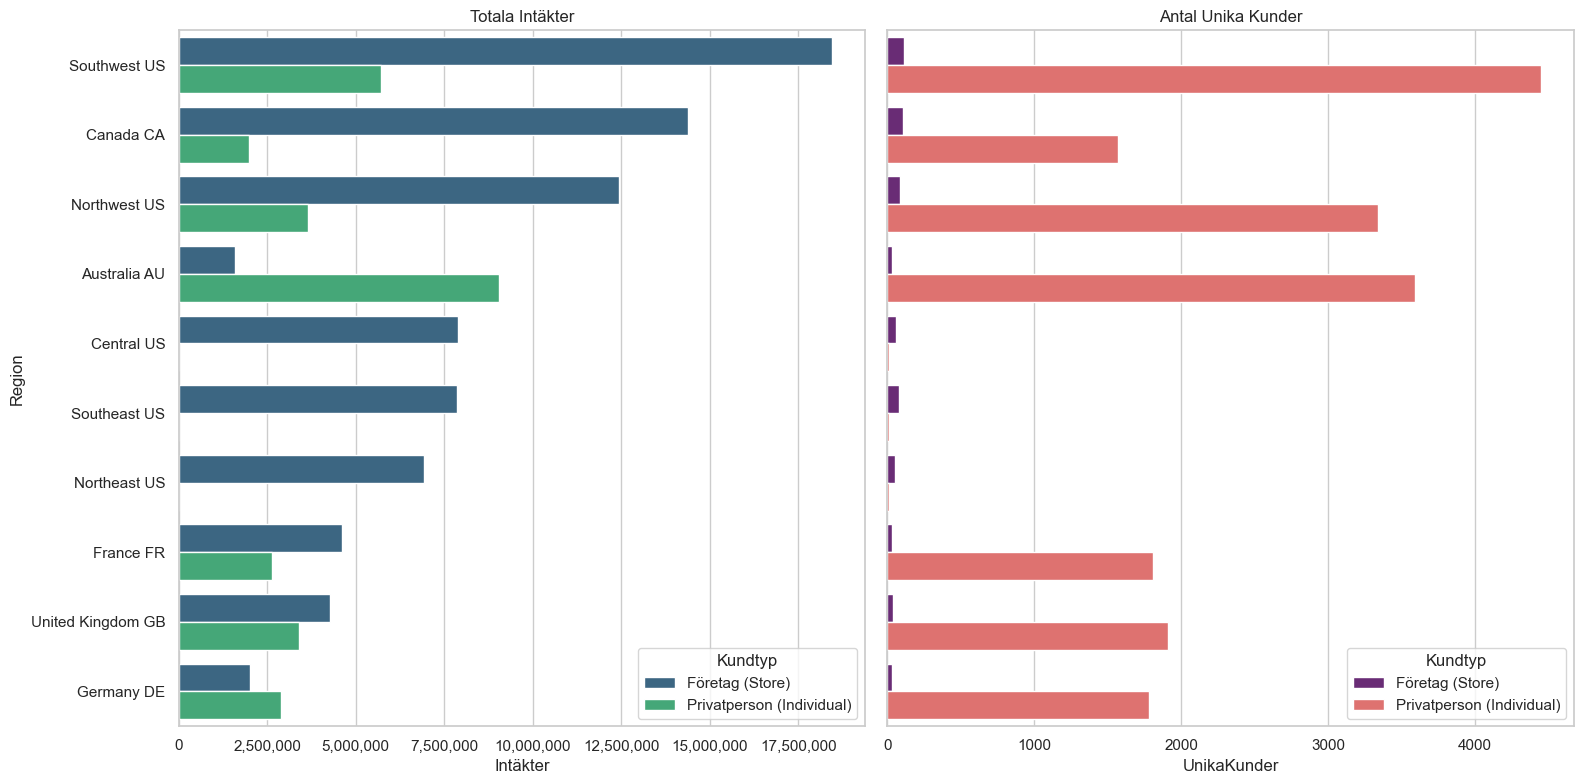

In [8]:
query_5 = """
SELECT 
    CONCAT(st.Name, ' ', st.CountryRegionCode) AS Region,
    st.[Group] AS Kontinent,
    CASE 
        WHEN sc.StoreID IS NOT NULL THEN 'Företag (Store)'
        WHEN sc.PersonID IS NOT NULL THEN 'Privatperson (Individual)'
        ELSE 'Övrigt'
    END AS Kundtyp,
    COUNT(DISTINCT sc.CustomerID) AS UnikaKunder, 
    SUM(soh.SubTotal) AS Intäkter,
    SUM(soh.SubTotal) / COUNT(DISTINCT sc.CustomerID) AS SnittIntäktPerKund,
    st.CountryRegionCode AS Regioncode
FROM Sales.SalesTerritory st
LEFT JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
LEFT JOIN Sales.Customer sc ON soh.CustomerID = sc.CustomerID
GROUP BY 
    st.Name, 
    st.CountryRegionCode, 
    st.[Group],
    CASE 
        WHEN sc.StoreID IS NOT NULL THEN 'Företag (Store)'
        WHEN sc.PersonID IS NOT NULL THEN 'Privatperson (Individual)'
        ELSE 'Övrigt'
    END
ORDER BY Intäkter DESC;
"""

query_5_df = query_df(query_5)
query_5_df_grouped_by_regioncode = query_5_df.groupby(['Regioncode'])[['UnikaKunder', 'Intäkter']].sum().reset_index().sort_values('Intäkter', ascending=False)

ax = query_5_df_grouped_by_regioncode.plot(
    x='Regioncode', 
    y=['Intäkter', 'UnikaKunder'],
    kind='bar',
    logy=True, 
    figsize=(10, 6))
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=9, fmt='%.0f')
ax.set_yticklabels([])
plt.title('Intäkter och unika kunder per land')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0) 
plt.legend(title='Staplar')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Stapeldiagram 1: Intäkter
sns.barplot(data=query_5_df, x='Intäkter', y='Region', hue='Kundtyp', ax=ax1, palette='viridis')
ax1.set_title("Totala Intäkter")
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Stapeldiagram 2: Unika Kunder 
sns.barplot(data=query_5_df, x='UnikaKunder', y='Region', hue='Kundtyp', ax=ax2, palette='magma')
ax2.set_title("Antal Unika Kunder")

plt.tight_layout()
plt.show()


**Lärdomar**
Vi ser i det första stapeldiagrammet att USA totalt dominerar intäkterna i förhållande till resterande länder, men vid djupare analys i de övriga 2 stapeldiagrammen så kan vi där urskilja att Kanada ligger på plats 2 bland intäkter per region, och är alltså mycket starkare intäktsmässigt än majoriteten av regionerna i USA.

Vi ser även i stapeldiagram 2 och 3 att majoriteten av unika kunder består av privatpersoner, medan majoriteten av intäkterna genereras av företag i samtliga regioner förutom Australien och Tyskland, där privatpersoner faktiskt står för en större del av intäkterna än företagen.

Vi lägger också märke till att vissa regioner helt saknar privatpersoner som kunder, och därför kan vi dra slutsatsen att dessa företag enbart säljer till företag.

Dessa stapeldiagram ger insikt i hur exempelvis marknadsföringsbudgeten bör proportioneras, där budgeten i de regioner som innehar företag som sin största kundbas bör satsa på B2B-Account Managers medan de regioner där privatperson är deras främsta kundkrets istället bör ha en betydande andel av deras marknadsföringsbudget satt till B2C kampanjer/marknadsföring.

______

#### Snittorder per region och kundtyp
**Affärsfråga**
* Hur ser genomsnittsordern i intäkt ut för de olika regionerna och kundtyperna?

**Metod**

SQL query där jag grupperar enligt regioner och kundtyper, och beräknar det genomsnittliga ordervärdet genom att ta totala intäkter dividerat med antal ordrar.

Sedan visualiserar jag detta i ett stapeldiagram rangordnat för högst genomsnittligt ordervärde först.
Detta ger en inblick i hur "viktig" varje kund är för respektive region och kundtyp.

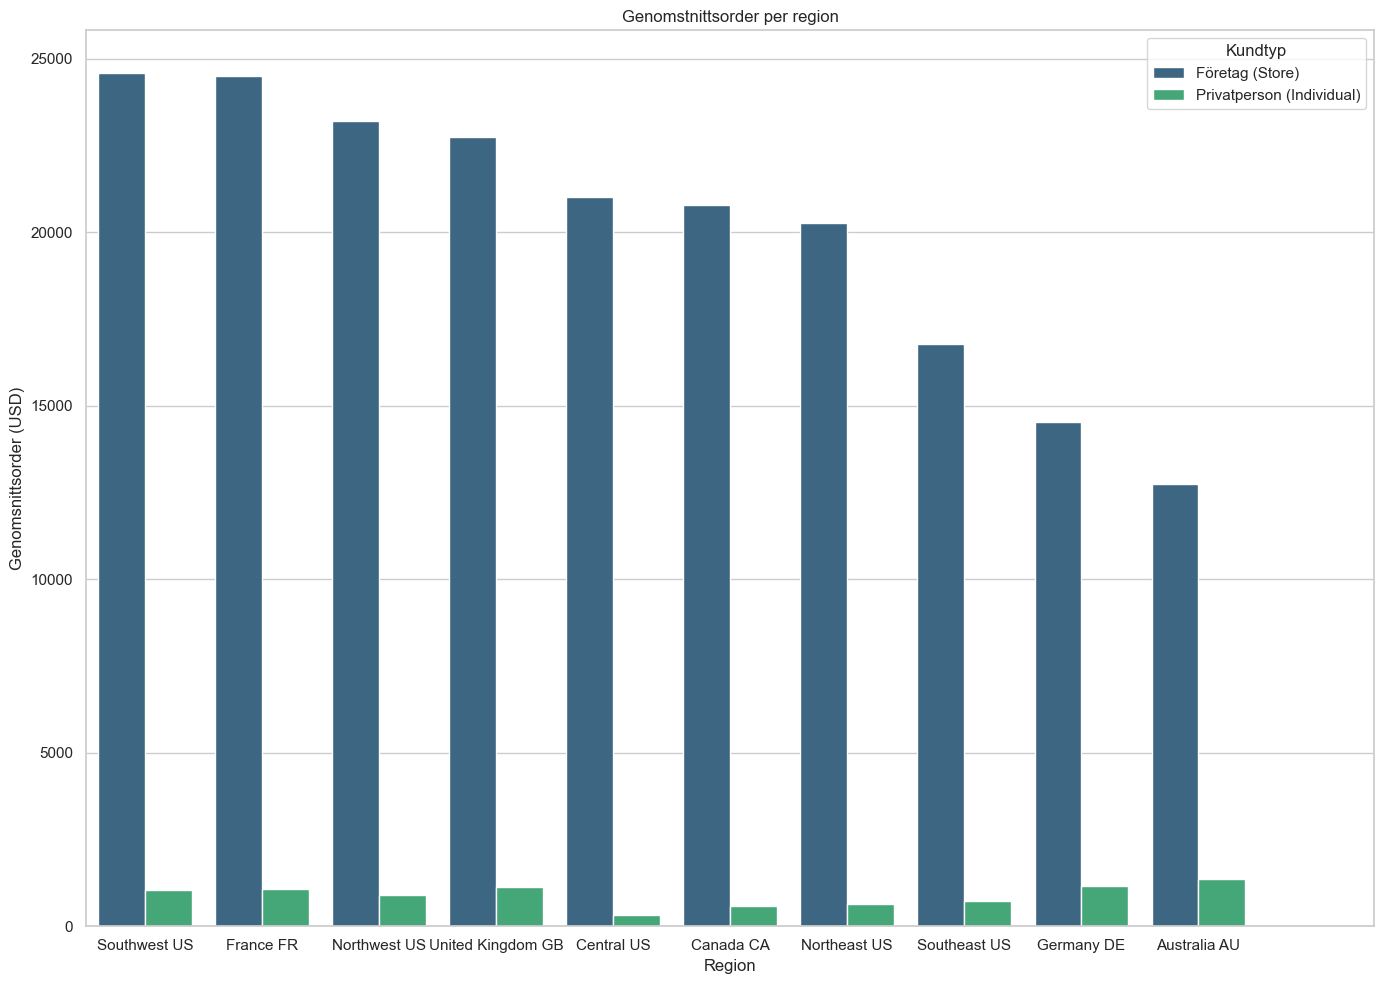

In [9]:
query_6 = """
SELECT CONCAT(st.Name, ' ', st.CountryRegionCode) AS Region,
    st.[Group] AS Kontinent,     
    CASE 
        WHEN sc.StoreID IS NOT NULL THEN 'Företag (Store)'
        WHEN sc.PersonID IS NOT NULL THEN 'Privatperson (Individual)'
        ELSE 'Övrigt'
    END AS Kundtyp,
    COUNT(DISTINCT soh.SalesOrderID) AS AntalOrdrar,
    (SUM(soh.SubTotal) / NULLIF(COUNT(DISTINCT soh.SalesOrderID), 0)) AS AOV
FROM sales.customer sc 
LEFT JOIN sales.store ss ON sc.StoreID = ss.BusinessEntityID
LEFT JOIN sales.SalesOrderHeader soh ON sc.CustomerID = soh.CustomerID
LEFT JOIN sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.name, 
    st.CountryRegionCode,
    st.[Group],
    CASE 
        WHEN sc.StoreID IS NOT NULL THEN 'Företag (Store)'
        WHEN sc.PersonID IS NOT NULL THEN 'Privatperson (Individual)'
        ELSE 'Övrigt'
    END
ORDER BY AOV DESC
"""

query_6_df = query_df(query_6)

fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(data=query_6_df, x='Region', y='AOV', hue='Kundtyp', ax=ax, palette='viridis')
ax.set_title("Genomstnittsorder per region")
ax.set_ylabel('Genomsnittsorder (USD)')
plt.tight_layout()
plt.show()

**Lärdomar**

Den genomsnittliga orderintäkten för företagskunder är betydligt högre än privatpersoner, vilket var väntat. 

Däremot ser vi att regionen Centrala USAs kunder som består av privatpersoner spenderar betydligt mindre per order än vad övriga regioner gör. En regional produktanalys hade behövts för att se vilka produkter som säljs bäst i respektive region för att förstå varför trenden ser ut som den gör. Vi ser även att Australiens privatkunder spenderar mer per order än vad övriga regioners privatkunder gör. Vilka produkter är det som säljer bäst i Australien i förhållande till övriga kunder? Vidare analys krävs.

En intressant iakttagelse är att Frankrike och Sydvästra USAs privatkunder och företagskunder tycks spendera ett likvärdigt belopp per order. Skulle det kunna röra sig om att samma typ av produkter är populära i dessa regioner? Vidare analys krävs.

______

#### Produkters vinster/förluster för AdventureWorks
**Affärsfråga**

* Vilka produkter genererade störst vinst för AdventureWorks?
* Vilka produkter genererade minst eller till och med negativt nettoresultat för AdventureWorks?
* Finns det produkter vi bör sluta sälja?
* Finns det produkter med högt antal sälj men med lågt nettoresultat?

**Metod**

* Jag jämför det genomsnittliga försäljningspriset med produktions och inköpspriset för en vara för att ta reda på vinstmarginalen. 
* Jämför antal producerade/inköpta med antal sålda/antal produkter i lagret.
* Jämför det viktade realiserade nettoresultatet (vinsten för AdventureWorks) för respektive produkt.
* Visualiserar detta i pivot-tabeller och bubbel-grafer för att få en översikt i produkternas prestationer
* Skapar enskilda bubbel-grafer och pivot-tabeller med vinnare respektive förlorare för att få mer nischade insikter och kunna ge relevanta rekommendationer.

In [10]:
query_7 = """
DECLARE @MaxYear INT;
SELECT @MaxYear = MAX(YEAR(OrderDate)) FROM Sales.SalesOrderHeader;

WITH SalesData AS (
    SELECT 
        sod.ProductID,
        SUM(sod.OrderQty) AS AntalSåldaTotalt,
        SUM(CASE WHEN YEAR(soh.OrderDate) = @MaxYear THEN sod.OrderQty ELSE 0 END) AS AntalSåldaIÅr,
        SUM(sod.LineTotal) AS TotalIntäkt,
        SUM(CASE WHEN YEAR(soh.OrderDate) = @MaxYear THEN sod.LineTotal ELSE 0 END) AS IntäktIÅr
    FROM Sales.SalesOrderDetail sod
    JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
    GROUP BY sod.ProductID
),
PurchaseData AS (
    SELECT 
        pod.ProductID,
        SUM(pod.OrderQty) AS AntalInköptaTotalt,
        SUM(CASE WHEN YEAR(poh.OrderDate) = @MaxYear THEN pod.OrderQty ELSE 0 END) AS AntalInköptaIÅr,
        SUM(pod.LineTotal) AS InköpsKostnadTotalt,
        SUM(CASE WHEN YEAR(poh.OrderDate) = @MaxYear THEN pod.LineTotal ELSE 0 END) AS InköpsKostnadIÅr
    FROM Purchasing.PurchaseOrderDetail pod
    JOIN Purchasing.PurchaseOrderHeader poh ON pod.PurchaseOrderID = poh.PurchaseOrderID
    GROUP BY pod.ProductID
),
ProductionData AS (
    SELECT 
        ProductID,
        SUM(StockedQty) AS AntalProduceradeTotalt,
        SUM(CASE WHEN YEAR(EndDate) = @MaxYear THEN StockedQty ELSE 0 END) AS AntalProduceradeIÅr
    FROM Production.WorkOrder
    GROUP BY ProductID
),
InventoryData AS (
    SELECT 
        ProductID,
        SUM(Quantity) AS FaktisktLagerJustNu
    FROM Production.ProductInventory
    GROUP BY ProductID
),

VolumeCalculation AS (
    SELECT 
        p.ProductID,
        p.Name,
        p.ListPrice,
        p.StandardCost,
        sd.AntalSåldaTotalt,
        sd.AntalSåldaIÅr,
        sd.TotalIntäkt,
        sd.IntäktIÅr,
        ISNULL(pd.AntalInköptaTotalt, 0) AS AntalInköptaTotalt,
        ISNULL(pd.AntalInköptaIÅr, 0) AS AntalInköptaIÅr,
        ISNULL(pd.InköpsKostnadTotalt, 0) AS InköpsKostnadTotalt,
        ISNULL(pd.InköpsKostnadIÅr, 0) AS InköpsKostnadIÅr,
        ISNULL(prod.AntalProduceradeTotalt, 0) AS AntalProduceradeTotalt,
        ISNULL(prod.AntalProduceradeIÅr, 0) AS AntalProduceradeIÅr,
        ISNULL(inv.FaktisktLagerJustNu, 0) AS FaktisktLagerJustNu,
        -- Beräknad totalvolym
        CASE 
            WHEN (ISNULL(pd.AntalInköptaTotalt, 0) + ISNULL(prod.AntalProduceradeTotalt, 0)) > (sd.AntalSåldaTotalt + ISNULL(inv.FaktisktLagerJustNu, 0))
            THEN (ISNULL(pd.AntalInköptaTotalt, 0) + ISNULL(prod.AntalProduceradeTotalt, 0))
            ELSE (sd.AntalSåldaTotalt + ISNULL(inv.FaktisktLagerJustNu, 0))
        END AS TotaltProduceradeEllerInköptaVaror
    FROM Production.Product p
    INNER JOIN SalesData sd ON p.ProductID = sd.ProductID
    LEFT JOIN PurchaseData pd ON p.ProductID = pd.ProductID
    LEFT JOIN ProductionData prod ON p.ProductID = prod.ProductID
    LEFT JOIN InventoryData inv ON p.ProductID = inv.ProductID
    WHERE p.ListPrice > 0
)
SELECT 
    Name AS ProduktNamn,
    AntalSåldaTotalt,
    AntalSåldaIÅr,
    FaktisktLagerJustNu AS LagerPåHyllan,
    TotaltProduceradeEllerInköptaVaror,
    
    -- Årets aktivitet
    AntalInköptaIÅr + AntalProduceradeIÅr AS InkommetIÅr,
    
    -- Totala resultat
    TotalIntäkt,
    InköpsKostnadTotalt + (AntalProduceradeTotalt * StandardCost) AS TotalUtgift,
    ((TotalIntäkt / NULLIF(AntalSåldaTotalt, 0)) - StandardCost) * (AntalSåldaTotalt) AS RealiseratNettoresultat,
    
    -- Årets resultat
    IntäktIÅr,
    InköpsKostnadIÅr + (AntalProduceradeIÅr * StandardCost) AS UtgiftIÅr,
    IntäktIÅr - (InköpsKostnadIÅr + (AntalProduceradeIÅr * StandardCost)) AS NettoresultatIÅr,
    
    -- Förväntad vinst
    (ListPrice - StandardCost) * (AntalSåldaTotalt + FaktisktLagerJustNu) AS TotalFörväntadVinst,
  ((TotalIntäkt / NULLIF(AntalSåldaTotalt, 0)) - StandardCost) * FaktisktLagerJustNu AS PotentiellVinstILager,
    
    -- Produktinformation
    TotalIntäkt / NULLIF(AntalSåldaTotalt, 0) AS GenomsnittligtFörsäljningspris,
    StandardCost AS KostnadPerEnhet,
    ListPrice AS FörsäljningsprisPrivatKund,
    (TotalIntäkt / NULLIF(AntalSåldaTotalt, 0) - StandardCost) / ((TotalIntäkt / NULLIF(AntalSåldaTotalt, 0))) AS ProcentuellVinstMarginal,
    CASE 
        WHEN (FaktisktLagerJustNu + AntalSåldaTotalt > 0.9 * TotaltProduceradeEllerInköptaVaror)
            THEN 'Huvudanvändning: Säljes'
        ELSE 'Huvudanvändning: Övrigt'
    END AS AnvändningAvProdukt,
    CASE
        WHEN ((TotalIntäkt / NULLIF(AntalSåldaTotalt, 0)) > StandardCost)
            THEN 'Sålt med vinst per produkt'
        ELSE 'Ut-reat'
    END AS TypAvFörsäljning

FROM VolumeCalculation
--WHERE FaktisktLagerJustNu + AntalSåldaTotalt > 0.9 * TotaltProduceradeEllerInköptaVaror
    --AND (TotalIntäkt / NULLIF(AntalSåldaTotalt, 0)) > StandardCost
ORDER BY RealiseratNettoresultat ASC;
"""
query_7_df = query_df(query_7)




query_7_df_annat_användningsområde = query_7_df[query_7_df['AnvändningAvProdukt'] == 'Huvudanvändning: Övrigt'].head(10)
pivot_df = query_7_df_annat_användningsområde.pivot_table(
    index='ProduktNamn', 
    values=['AntalSåldaTotalt', 'LagerPåHyllan', 'TotaltProduceradeEllerInköptaVaror']
)
snygg_stil_pivot = pivot_df.style.set_properties(**{'text-align': 'left'})
display(snygg_stil_pivot)




,AntalSåldaTotalt,LagerPåHyllan,TotaltProduceradeEllerInköptaVaror
ProduktNamn,,,
"HL Road Frame - Black, 44",459.000000,0.000000,2100.000000
"HL Road Frame - Red, 44",486.000000,0.000000,1817.000000
"HL Road Frame - Red, 62",485.000000,0.000000,1085.000000
"LL Road Frame - Black, 52",1581.000000,0.000000,5180.000000
"LL Road Frame - Black, 58",940.000000,0.000000,3695.000000
"ML Road Frame-W - Yellow, 38",895.000000,796.000000,2630.000000
"ML Road Frame-W - Yellow, 44",1435.000000,0.000000,2897.000000
"ML Road Frame-W - Yellow, 48",889.000000,0.000000,4270.000000
"Short-Sleeve Classic Jersey, L",2848.000000,36.000000,6000.000000


**Notering i datan**

Innan vi djupdyker in i affärsfrågorna så är detta en upptäckt: Totalt producerade + Totalt inköpta varor överenstämmer inte alltid med Totalt antal sålda varor + Varor som finns i sortimentet.

Om vi köper in 100 balonger, för att säljas, så måste vi anta att dessa balonger antingen har sålts eller finns på lagerhyllan. Men här visar det sig att vissa produkter aldrig når försäljning eller lagerhyllan. 

**Möjliga orsaker**
* Andra användningsområden - Detta är det mest troliga då majoriteten av produkterna är komponenter, och det är möjligt att AdventureWorks bygger cyklar med komponenterna.
* Svinn/defekter/återlämning - Produkter som ej säljs skulle eventuellt kunna lämnas tillbaka till fabrik som sedan säljer dem vidare till andra återförsäljare för ett rabatterat pris. Alternativt så kastas en del produkter som ej sålts under längre tid.
* Stöld - En mer långsökt anledning men vissa av de saknade produkterna skulle kunna förklaras av stölder.

Vid vidare analys av realiserat nettoresultat så kommer dessa produkter att missgynnas då de på pappret enbart genererat förlust. Därför behöver vi exkludera dem i vidare analyser.

In [11]:
query_7_df_rea = query_7_df[
    (query_7_df['AnvändningAvProdukt'] == 'Huvudanvändning: Säljes') &
    (query_7_df['TypAvFörsäljning'] == 'Ut-reat')
]
pivot_rea = query_7_df_rea.pivot_table(
    index='ProduktNamn',
    values=[
        'RealiseratNettoresultat', 
        'ProcentuellVinstMarginal', 
        'GenomsnittligtFörsäljningspris', 
        'KostnadPerEnhet'
    ]
)
pivot_sorted = pivot_rea.sort_values(by='RealiseratNettoresultat', ascending=True).head(10)
snygg_stil_pivot = pivot_sorted.style.set_properties(**{'text-align': 'left'})
display(snygg_stil_pivot)


,GenomsnittligtFörsäljningspris,KostnadPerEnhet,ProcentuellVinstMarginal,RealiseratNettoresultat
ProduktNamn,,,,
"Road-650 Red, 44",418.518438,486.706600,-0.162927,-153696.117148
"Touring-1000 Yellow, 60",1362.776571,1481.937900,-0.087440,-132745.720506
"Road-650 Red, 60",455.434148,486.706600,-0.068665,-69800.112864
"Touring-1000 Yellow, 46",1419.276486,1481.937900,-0.044150,-62974.721070
"Road-650 Black, 52",459.431620,486.706600,-0.059366,-61914.204600
"Long-Sleeve Logo Jersey, L",30.150936,38.492300,-0.276653,-54986.271488
"Road-650 Red, 62",464.044271,486.706600,-0.048836,-42967.775784
"Road-650 Black, 58",464.795714,486.706600,-0.047140,-40995.267706
"Road-650 Red, 48",465.395478,486.706600,-0.045791,-40235.398336


**Notering i datan**

En observation görs när det framkommer att vissa produkter har sålts med ett negativt resultat, dvs det genomsnittliga försäljningspriset har överstigit kostnaden att köpa in eller producera varan. 

En given rekommendation är då att höja vinstmarginalen, men en mer logisk följdfråga till observationen är Varför dessa produkter har reats ut.

**Möjliga förklaringar**
* Produkter som inte sålt bra reas ut för att ge utrymme åt nya produkter 
* Produkter reas ut för att locka kunder till varuhus/onlinehandel som marknadsföringskampanjer

Bägge dessa förklaringar är direkt medvetna handlingar från ledningen vilket gör att rekommendationer som "höj vinstmarginalen" för dessa produkter blir totalt onödigt. 

Skulle dessa förklaringsmodeller dock inte vara skälet, utan det handlar om en omedvetenhet eller ett systematiskt fel så rekommenderas en omedelbar höjning av vinstmarginalen, samt en utredning av den faktiska orsaken till den negativa vinstmarginalen.

Vid vidare analys av vilka produkter som presterar sämre än övriga, och för att kunna ge relevanta rekommendationer, så utesluts nu dessa produkter med negativ vinstmarginal från nedanstående analys.

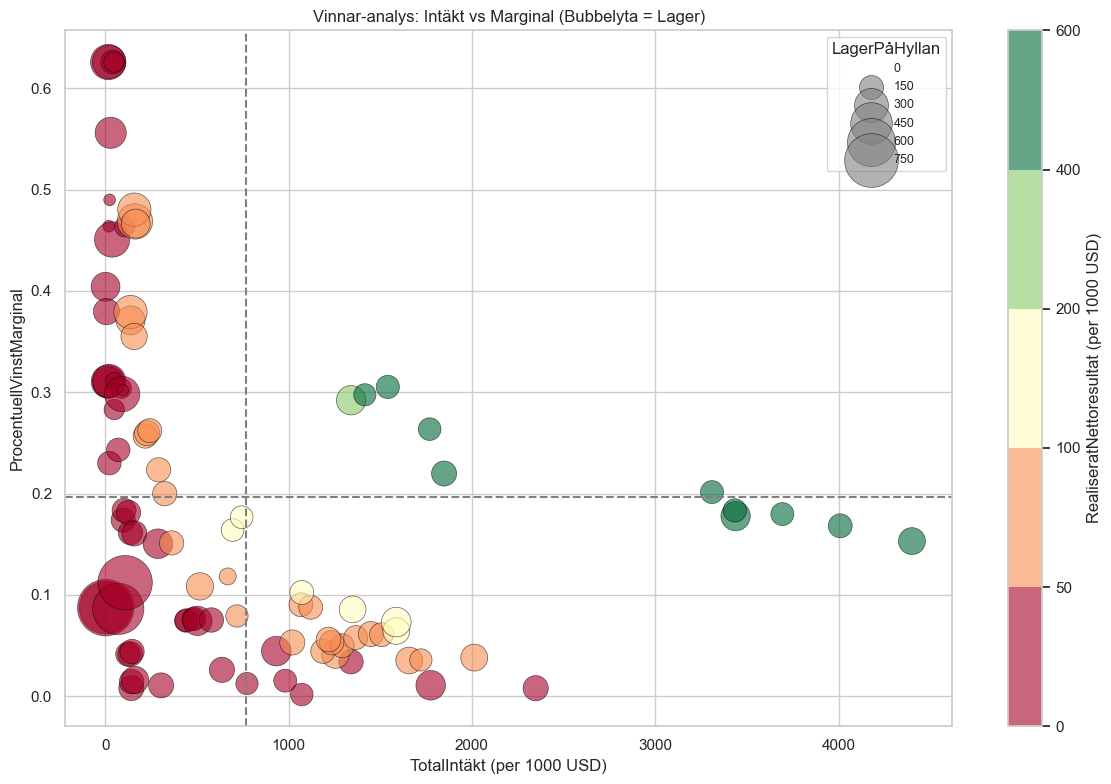

In [12]:
# Dataframe utan utreade produkter och produkter som ej enbart sålts
query_7_df_copy = query_7_df[
     (query_7_df['AnvändningAvProdukt'] == 'Huvudanvändning: Säljes') &
    (query_7_df['TypAvFörsäljning'] == 'Sålt med vinst per produkt')
].copy()

# FIXA: Dividera från den kopierade DataFrame, inte från originalet
query_7_df_copy['RealiseratNettoresultat'] = query_7_df_copy['RealiseratNettoresultat'] / 1000
query_7_df_copy['TotalIntäkt'] = query_7_df_copy['TotalIntäkt'] / 1000

levels = [0, 50, 100, 200, 400, 600]
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

# --- FÖRSTA FIGUREN (alla bubblor) ---
plt.figure(figsize=(12, 8))

scatter1 = plt.scatter(
    x=query_7_df_copy['TotalIntäkt'],
    y=query_7_df_copy['ProcentuellVinstMarginal'],
    s=query_7_df_copy['LagerPåHyllan'] * 2,
    c=query_7_df_copy['RealiseratNettoresultat'],
    cmap='RdYlGn',
    norm=norm,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

cbar1 = plt.colorbar(scatter1, ticks=levels)
cbar1.set_label('RealiseratNettoresultat (per 1000 USD)')

size_values = [0, 150, 300, 450, 600, 750]
legend_elements = []
for size_val in size_values:
    legend_elements.append(
        plt.scatter([], [], s=size_val*2, c='gray', alpha=0.6, edgecolors='black', linewidth=0.5)
    )

legend1 = plt.legend(
    legend_elements, 
    [str(val) for val in size_values], 
    scatterpoints=1, 
    title='LagerPåHyllan',
    loc='upper right',
    frameon=True,
    fontsize=9
)

plt.axhline(query_7_df_copy['ProcentuellVinstMarginal'].mean(), color='grey', linestyle='--')
plt.axvline(query_7_df_copy['TotalIntäkt'].mean(), color='grey', linestyle='--')

plt.title('Vinnar-analys: Intäkt vs Marginal (Bubbelyta = Lager)')
plt.xlabel('TotalIntäkt (per 1000 USD)')
plt.ylabel('ProcentuellVinstMarginal')
plt.tight_layout()
plt.show()


Nu när produkterna med negativ vinstmarginal samt produkterna som ej nåt lagerhyllan är bortfiltrerade så återstår produkter visualiserade ovan. 

**Vi väljer att analysera dessa produkter i 3 steg:**

1. Gröna bubblor - Produkter med högt realiserat nettoresultat
2. Röda stora bubblor - Produkter med lågt realiserat nettoresultat och stort innestående lager
3. Röda bubblor med lågt realiserat nettoresultat men med hög vinstmarginal eller höga intäkter

C:\Users\Jakob\AppData\Local\Temp\ipykernel_4444\1395136283.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  query_7_df_red_large = query_7_df_red_large[query_7_df_copy['RealiseratNettoresultat'] <= red_threshold].copy()


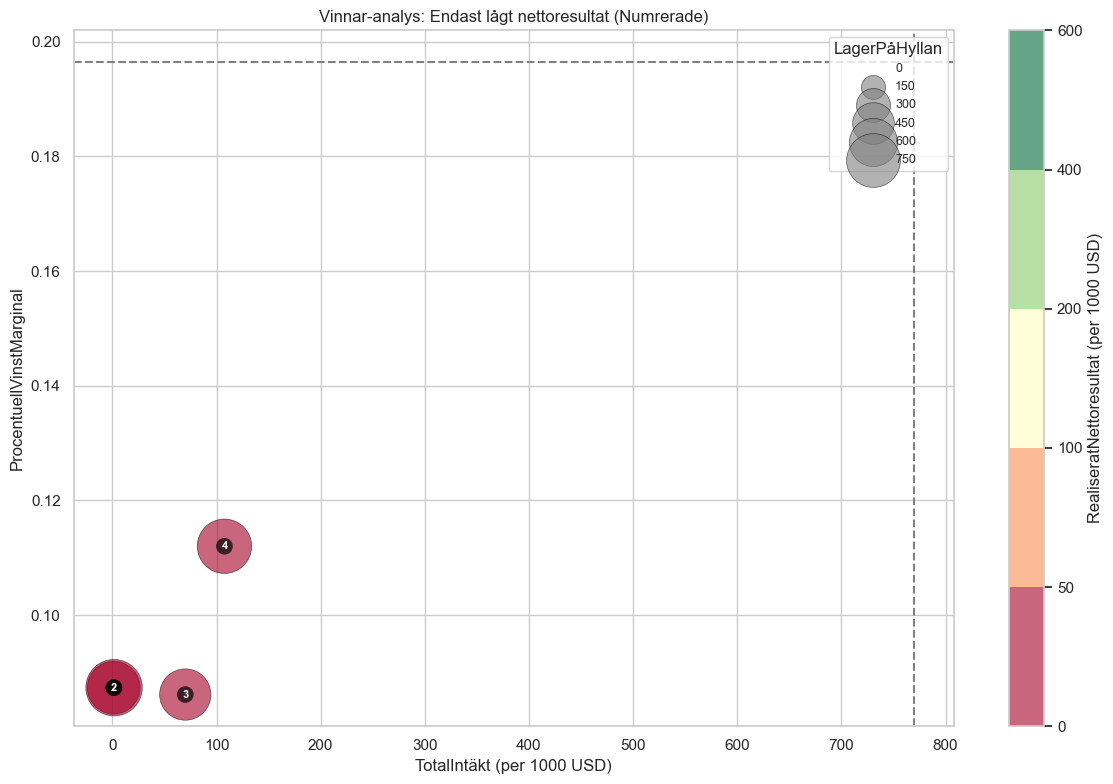

,ProduktNamn,TotalIntäkt,ProcentuellVinstMarginal,RealiseratNettoresultat,LagerPåHyllan
Nummer,,,,,
1,"LL Mountain Frame - Black, 40",1.198992,0.087333,0.104712,719
2,"ML Mountain Frame-W - Silver, 38",1.529178,0.087333,0.133548,826
3,"LL Mountain Frame - Silver, 40",69.934276,0.086135,6.023816,682
4,"ML Mountain Frame - Black, 38",107.557584,0.112000,12.046464,767


In [13]:
red_threshold = 40
query_7_df_red_large = query_7_df_copy[
    (query_7_df_copy['LagerPåHyllan'] > 650)
].copy()
query_7_df_red_large = query_7_df_red_large[query_7_df_copy['RealiseratNettoresultat'] <= red_threshold].copy()

query_7_df_red_large = query_7_df_red_large.sort_values('RealiseratNettoresultat', ascending=True)
query_7_df_red_large['Nummer'] = range(1, len(query_7_df_red_large) + 1)

plt.figure(figsize=(12, 8))

scatter2 = plt.scatter(
    x=query_7_df_red_large['TotalIntäkt'],
    y=query_7_df_red_large['ProcentuellVinstMarginal'],
    s=query_7_df_red_large['LagerPåHyllan'] * 2,
    c=query_7_df_red_large['RealiseratNettoresultat'],
    cmap='RdYlGn',
    norm=norm,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

for idx, row in query_7_df_red_large.iterrows():
    plt.text(
        row['TotalIntäkt'], 
        row['ProcentuellVinstMarginal'], 
        str(row['Nummer']),
        fontsize=8,
        ha='center',
        va='center',
        fontweight='bold',
        color='white',
        bbox=dict(boxstyle='circle,pad=0.3', facecolor='black', alpha=0.7, edgecolor='none')
    )

cbar2 = plt.colorbar(scatter2, ticks=levels)
cbar2.set_label('RealiseratNettoresultat (per 1000 USD)')

legend_elements2 = []
for size_val in size_values:
    legend_elements2.append(
        plt.scatter([], [], s=size_val*2, c='gray', alpha=0.6, edgecolors='black', linewidth=0.5)
    )

legend2 = plt.legend(
    legend_elements2, 
    [str(val) for val in size_values], 
    scatterpoints=1, 
    title='LagerPåHyllan',
    loc='upper right',
    frameon=True,
    fontsize=9
)

plt.axhline(query_7_df_copy['ProcentuellVinstMarginal'].mean(), color='grey', linestyle='--')
plt.axvline(query_7_df_copy['TotalIntäkt'].mean(), color='grey', linestyle='--')

plt.title('Vinnar-analys: Endast lågt nettoresultat (Numrerade)')
plt.xlabel('TotalIntäkt (per 1000 USD)')
plt.ylabel('ProcentuellVinstMarginal')
plt.tight_layout()
plt.show()


pivot_red = query_7_df_red_large[['Nummer', 'ProduktNamn', 'TotalIntäkt', 'ProcentuellVinstMarginal', 
                             'RealiseratNettoresultat', 'LagerPåHyllan']].sort_values('RealiseratNettoresultat')
pivot_red.set_index('Nummer', inplace=True)
display(pivot_red.style.set_properties(**{'text-align': 'left'}))


Här ser vi 4 produkter vars innestående lager överstiger 650 samt att produkterna visat ett relativt lågt realiserat nettoresultat. Låt oss djupdyka i produkterna.

* Produkt nummer 3 och 4: Här har vi två intressanta produkter, då intäkterna är höga (69.900 och 107.500) men eftersom vinstmarginalerna ligger på ynka 8.7 och 11.2% så genererar inte dessa två produkter någon större vinst. Det AdventureWorks skulle kunna testa är att successivt öka priserna för just dessa två produkter så att vinstmarginal når upp till minst 15% och se om detta drabbar den totala försäljningen av produkterna. 

* Produkt nummer 1 och 2: Dessa två produkter har en väldigt låg intäkt samt en redan lågt satt vinstmarginal. Dessa två produkter rekommenderar jag bör sluta säljas, då man ej kan rättfärdiga en lägre satt vinstmarginal, då den redan är satt till 8.7%, och en lägre satt vinstmarignal kommer, trots möjlig ökad intäkt, ej att generera några hispande summor i realiserat nettoresultat.

Men i och med att lagret för dessa två produkter överstiger 700 så rekommenderar jag att, ifall behov av plats för nya mer populära produkter uppstår, rea ut produkterna. Ifall ett sådant behov ej uppstår så rekommenderar jag en långsiktig plan för att tömma lagret genom att sänka vinstmarginalen till 5%, och sluta köpa/producera dessa produkter helt. Ifall försäljningen ej ökar så kan man ytterligare sänka vinstmarginalen till 2.5%, för att på sikt tömma lagret.

C:\Users\Jakob\AppData\Local\Temp\ipykernel_4444\1560488093.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  query_7_df_red = query_7_df_red[query_7_df_copy['RealiseratNettoresultat'] <= red_threshold].copy()


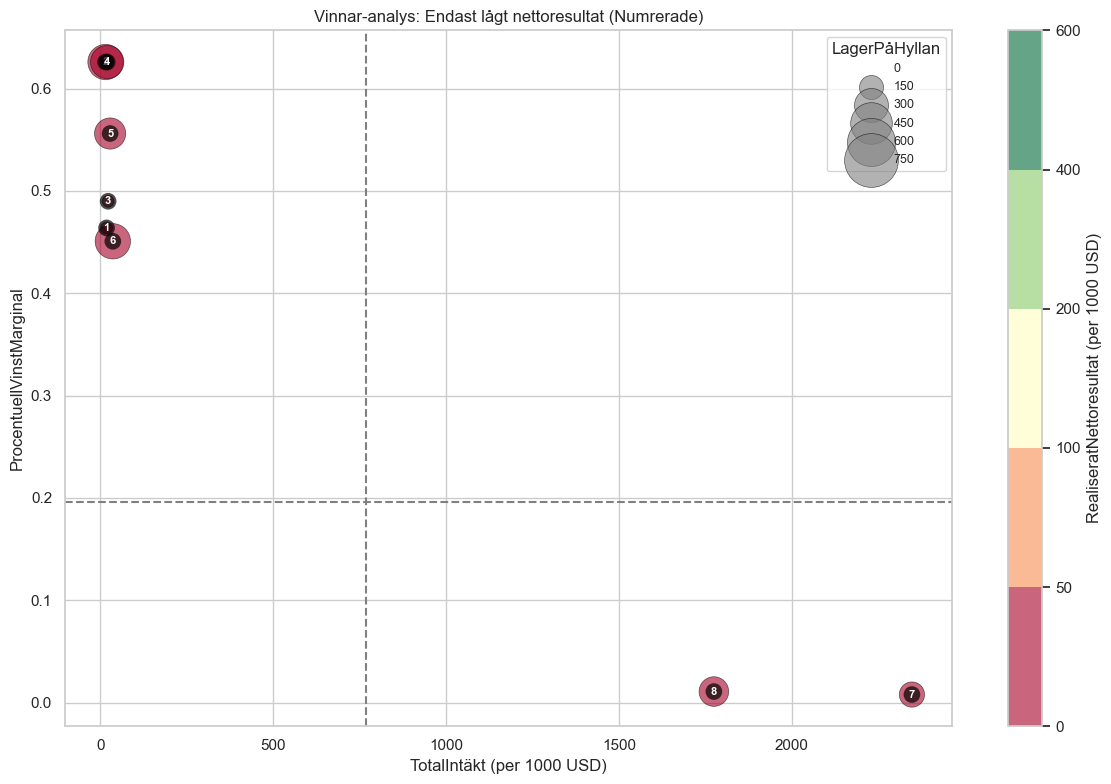

,ProduktNamn,TotalIntäkt,ProcentuellVinstMarginal,RealiseratNettoresultat,LagerPåHyllan
Nummer,,,,,
1,Bike Wash - Dissolver,18.406972,0.463877,8.538589,36
2,Road Bottle Cage,15.390880,0.625995,9.634622,324
3,"Half-Finger Gloves, L",22.912259,0.489912,11.224992,36
4,Mountain Bottle Cage,20.229750,0.625995,12.663742,288
5,Water Bottle - 30 oz.,28.654163,0.556126,15.935324,252
6,"Half-Finger Gloves, S",36.490551,0.450801,16.450001,324
7,"Road-250 Black, 48",2347.655953,0.007813,18.343999,165
8,"Road-350-W Yellow, 48",1774.883557,0.010734,19.052336,227


In [14]:
red_threshold = 22
query_7_df_red = query_7_df_copy[
    (query_7_df_copy['ProcentuellVinstMarginal'] > 0.45) | 
    (query_7_df_copy['TotalIntäkt'] > 1500)
].copy()
query_7_df_red = query_7_df_red[query_7_df_copy['RealiseratNettoresultat'] <= red_threshold].copy()

query_7_df_red = query_7_df_red.sort_values('RealiseratNettoresultat', ascending=True)
query_7_df_red['Nummer'] = range(1, len(query_7_df_red) + 1)

plt.figure(figsize=(12, 8))

scatter2 = plt.scatter(
    x=query_7_df_red['TotalIntäkt'],
    y=query_7_df_red['ProcentuellVinstMarginal'],
    s=query_7_df_red['LagerPåHyllan'] * 2,
    c=query_7_df_red['RealiseratNettoresultat'],
    cmap='RdYlGn',
    norm=norm,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

for idx, row in query_7_df_red.iterrows():
    plt.text(
        row['TotalIntäkt'], 
        row['ProcentuellVinstMarginal'], 
        str(row['Nummer']),
        fontsize=8,
        ha='center',
        va='center',
        fontweight='bold',
        color='white',
        bbox=dict(boxstyle='circle,pad=0.3', facecolor='black', alpha=0.7, edgecolor='none')
    )

cbar2 = plt.colorbar(scatter2, ticks=levels)
cbar2.set_label('RealiseratNettoresultat (per 1000 USD)')

legend_elements2 = []
for size_val in size_values:
    legend_elements2.append(
        plt.scatter([], [], s=size_val*2, c='gray', alpha=0.6, edgecolors='black', linewidth=0.5)
    )

legend2 = plt.legend(
    legend_elements2, 
    [str(val) for val in size_values], 
    scatterpoints=1, 
    title='LagerPåHyllan',
    loc='upper right',
    frameon=True,
    fontsize=9
)

plt.axhline(query_7_df_copy['ProcentuellVinstMarginal'].mean(), color='grey', linestyle='--')
plt.axvline(query_7_df_copy['TotalIntäkt'].mean(), color='grey', linestyle='--')

plt.title('Vinnar-analys: Endast lågt nettoresultat (Numrerade)')
plt.xlabel('TotalIntäkt (per 1000 USD)')
plt.ylabel('ProcentuellVinstMarginal')
plt.tight_layout()
plt.show()

pivot_red = query_7_df_red[['Nummer', 'ProduktNamn', 'TotalIntäkt', 'ProcentuellVinstMarginal', 
                             'RealiseratNettoresultat', 'LagerPåHyllan']].sort_values('RealiseratNettoresultat')
pivot_red.set_index('Nummer', inplace=True)
display(pivot_red.style.set_properties(**{'text-align': 'left'}))

I ovanstående visualisering och pivot-tabell ser vi produkter med ett lågt realiserat nettoresultat men med en högre vinstmarginal (över 45%) eller en hög intäkt (över 1700.000) och således låg vinstmarginal (mindre eller lika med 1%).

**Produktnummer**
* **1-6:** Dessa produkter har alla en låg intäkt men en mycket hög vinstmarginal (över 45%). Dessa produkter kan vi dela upp i två kategorier: 
Produkter med högt respektive lågt lagersaldo.

Produkter med högt lagersaldo (2, 4, 5, 6): Min rekommendation är att sänka den höga vinstmarginalen avsevärt för att se om intäkterna ökar. Exempel på det är att genomföra en marknadsföringskampanj där man tillfälligt sätter vinstmarginalen till 15% och använder det befintliga lagersaldot som ett marknadsföringsmedel som också genererar ett positivt realiserat nettoresultat.

Produkter med lågt lagersaldo (1, 3): Dessa produkter, i och med det låga lagersaldot och risken med att köpa in fler produkter då de också ger en låg intäkt, rekommenderar jag istället att man lokalt rear ut, men ej använder som ett marknadsföringsmedel då lagret snabbt kommer ta slut vilket gör potentiella kunder besvikna. Exempelvis rear ut på en plats med blandade produkter med 50-70% rea.

* **7-8:** Dessa produkter är intressanta då de har en hög intäkt (över 1700.000) men en mycket låg vinstmarginal (1% och 0.7%). Frågan är vad som händer med intäkterna om man ökar vinstmarginalen. Om tanken är att dessa produkter ska locka till sig kunder som sedan köper andra produkter med högre vinstmarginaler så bör man utreda om strategin fungerar genom att se hur snittkunden som handlar dessa produkter också handlar andra produkter med högre vinstmarginal, genom att kolla snitt-vinstmarginalen för varukorgarna hos kunder som handlar just dessa två produkter.

Annars är min rekommendation att successivt höja vinstmarginalerna till ett mål på 10%, förutsatt att detta inte drabbar intäkterna i allt för hög utsträckning.

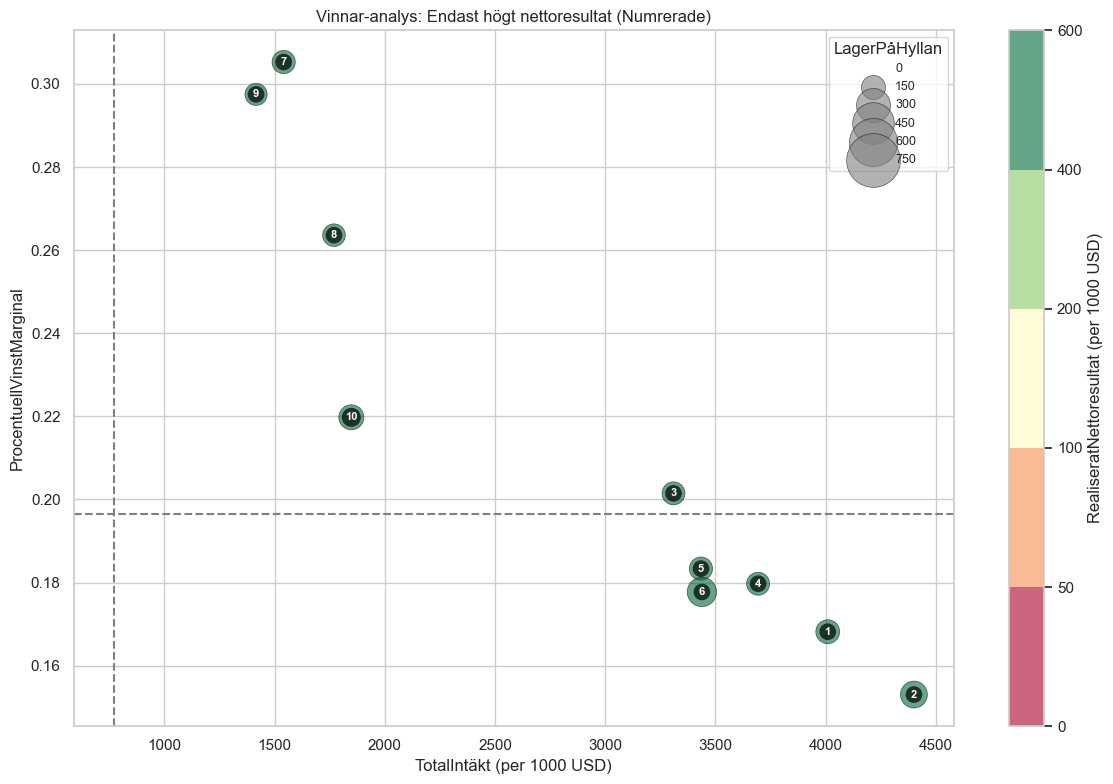

,ProduktNamn,TotalIntäkt,ProcentuellVinstMarginal,RealiseratNettoresultat,LagerPåHyllan
Nummer,,,,,
1,"Mountain-200 Black, 42",4009.494762,0.168154,674.216578,148
2,"Mountain-200 Black, 38",4400.592800,0.153034,673.444469,188
3,"Mountain-200 Black, 46",3309.673217,0.201452,666.740691,137
4,"Mountain-200 Silver, 38",3693.678025,0.179708,663.784940,137
5,"Mountain-200 Silver, 46",3434.256942,0.183342,629.644128,140
6,"Mountain-200 Silver, 42",3438.478860,0.177719,611.084897,223
7,"Road-150 Red, 48",1540.803062,0.305266,470.355021,140
8,"Road-150 Red, 62",1769.096688,0.263592,466.320168,133
9,"Road-150 Red, 52",1415.563612,0.297486,421.110868,128


In [15]:
green_threshold = 400  
query_7_df_green = query_7_df_copy[query_7_df_copy['RealiseratNettoresultat'] >= green_threshold].copy()

query_7_df_green = query_7_df_green.sort_values('RealiseratNettoresultat', ascending=False)
query_7_df_green['Nummer'] = range(1, len(query_7_df_green) + 1)

plt.figure(figsize=(12, 8))

scatter3 = plt.scatter(
    x=query_7_df_green['TotalIntäkt'],
    y=query_7_df_green['ProcentuellVinstMarginal'],
    s=query_7_df_green['LagerPåHyllan'] * 2,
    c=query_7_df_green['RealiseratNettoresultat'],
    cmap='RdYlGn',
    norm=norm,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

for idx, row in query_7_df_green.iterrows():
    plt.text(
        row['TotalIntäkt'], 
        row['ProcentuellVinstMarginal'], 
        str(row['Nummer']),
        fontsize=8,
        ha='center',
        va='center',
        fontweight='bold',
        color='white',
        bbox=dict(boxstyle='circle,pad=0.3', facecolor='black', alpha=0.7, edgecolor='none')
    )

cbar3 = plt.colorbar(scatter3, ticks=levels)
cbar3.set_label('RealiseratNettoresultat (per 1000 USD)')

legend_elements3 = []
for size_val in size_values:
    legend_elements3.append(
        plt.scatter([], [], s=size_val*2, c='gray', alpha=0.6, edgecolors='black', linewidth=0.5)
    )

legend3 = plt.legend(
    legend_elements3, 
    [str(val) for val in size_values], 
    scatterpoints=1, 
    title='LagerPåHyllan',
    loc='upper right',
    frameon=True,
    fontsize=9
)

plt.axhline(query_7_df_copy['ProcentuellVinstMarginal'].mean(), color='grey', linestyle='--')
plt.axvline(query_7_df_copy['TotalIntäkt'].mean(), color='grey', linestyle='--')

plt.title('Vinnar-analys: Endast högt nettoresultat (Numrerade)')
plt.xlabel('TotalIntäkt (per 1000 USD)')
plt.ylabel('ProcentuellVinstMarginal')
plt.tight_layout()
plt.show()

pivot_green = query_7_df_green[['Nummer', 'ProduktNamn', 'TotalIntäkt', 'ProcentuellVinstMarginal', 
                                 'RealiseratNettoresultat', 'LagerPåHyllan']].sort_values('RealiseratNettoresultat', ascending=False)
pivot_green.set_index('Nummer', inplace=True)
display(pivot_green.style.set_properties(**{'text-align': 'left'}))

Ovanstående visualisering demonstrerar 10 produkter vars realiserade nettoresultat överstiger 400.000. Dessa produkter presterar bäst sett till ren vinst för AdventureWorks! 

Vi skulle kunna säga att hur dessa produkter är utformade Fungerar!

Men vill man nödvändigtvis experimentera med produkterna i hopp om att de ska prestera ännu bättre så rekommenderar jag att man experimenterar med att försiktigt sänka vinstmarginalerna för produkterna 7-10 (för att se om intäkterna därefter ökar), medan man försiktigt ökar vinstmarginalerna för produkterna 1, 2, 4, 5, 6 för att se om det realiserade nettoresultatet ökar (dvs om intäkterna ej minskar för drastiskt till följd av det ökade priset).

Man bör dock först göra en marknadsundersökning där man undersöker konkurrerande verksamheters prissättningar för att säkerställa att AdventureWorks egna prissättning förblir konkurrenskraftig. Vidare analys krävs!